# Quantum Gaussian Fitting VQE

Fitting of function.

See documentation https://docs.pennylane.ai/en/stable/

Notebook by: Óscar Amaro (2023)

In [5]:
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from numpy import pi
from numpy import sqrt, log, exp

from tqdm import trange
from scipy.special import kl_div

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pennylane==0.32.0


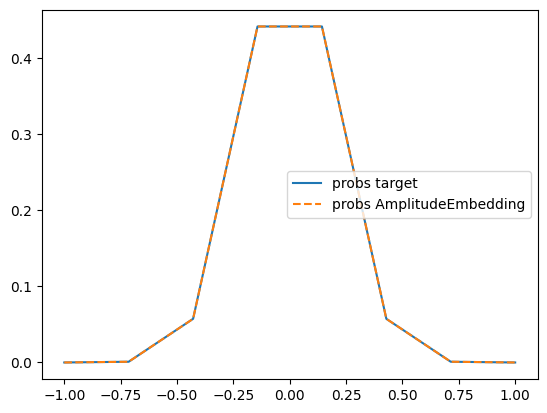

In [62]:
# main parameters
nqubits = 3
mu=0; sigma=0.2;

xmin = -1; xmax = 1;
xlst = np.linspace(xmin,xmax,2**nqubits)
probs_target = exp(-0.5*(xlst-mu)**2/sigma**2) # prob = |psi|^2
amps = sqrt(probs_target) # psi

# embedding amplitude directly with qml
dev = qml.device('default.qubit', wires=nqubits)
@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nqubits))
    return qml.probs(wires=[i for i in range(nqubits)])
probs_qml = circuit(f=amps/sqrt(np.sum( amps**2 )));

plt.plot(xlst, probs_target/np.sum(probs_target), label=r'probs target' )
plt.plot(xlst, probs_qml, '--', label=r'probs AmplitudeEmbedding')
plt.legend()
plt.show()

In [65]:
# now we compute the best weights for the entangler layers using an optimizer (AdagradOptimizer)
k=3 # number of entangler layers

@qml.qnode(dev)
def circuit(params):
    for i in range(k):
        x = params[0][i*nqubits:(i+1)*nqubits]
        qml.BasicEntanglerLayers(weights=[x], wires=range(nqubits))
    return qml.probs(wires=[i for i in range(nqubits)])
#print(circuit(params_new))

def cost(x):
    #return np.sum( kl_div(circuit(x), qml.numpy.tensor(probs_target) ) )
    return np.sum( np.abs(circuit([x])-probs_target)**2 )
#cost(params_new)

100%|█████████████████████████████████████████| 400/400 [00:15<00:00, 25.54it/s]


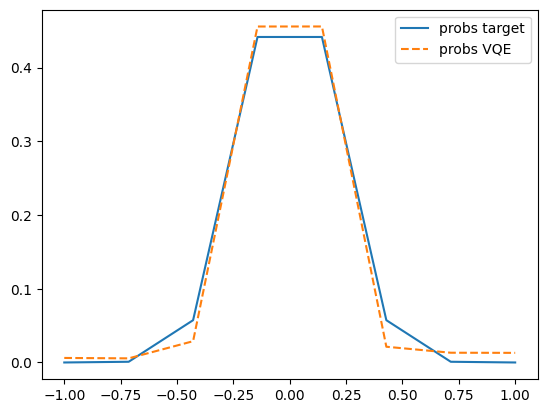

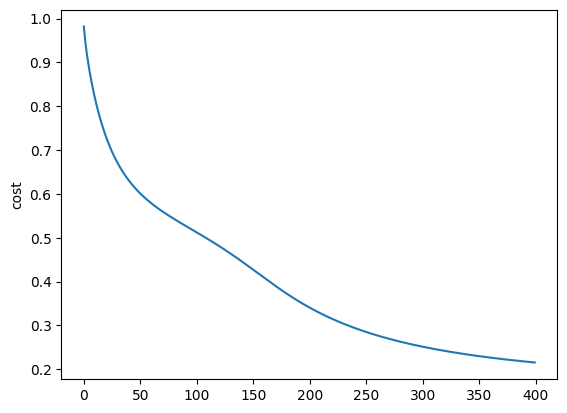

In [69]:
params_new = np.random.normal(0, np.pi, (k*nqubits, ))
#plt.plot( xlst, circuit([init_params_old]) )
#plt.show()

# initialise the optimizer
opt = qml.AdagradOptimizer(stepsize=0.03)
nsteps = 400 # set the number of steps

costlst = np.zeros(nsteps)
for i in trange(nsteps):
    # update the circuit parameters
    params_new = opt.step(cost, params_new)
    costlst[i] = cost(params_new)
    
plt.plot(xlst, probs_target/np.sum(probs_target), label=r'probs target' )
plt.plot( xlst, circuit([params_new]), '--', label=r'probs VQE' )
plt.legend()
plt.show()

plt.plot(costlst)
plt.ylabel(r'cost')
plt.show()